# Face recognition using neural network features

In this task, you have to construct face recognizer based on features extracted from the neural network. The task consists of two parts: image classification and video classification. In the first one you should classify distinct images and in the second one you will deal with short video sequences.

In [1]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [2]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.decomposition import PCA

In [3]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
import cPickle as pickle
from copy import copy

from get_data import download, load_dataset, load_faces

Populating the interactive namespace from numpy and matplotlib


In [4]:
def VGG_model(weight_path=None):
    
    input_shape = (224,224,3)
    model=Sequential()
    # Block 1
    model.add(Convolution2D(64, (3, 3), activation='relu', padding='same', name='conv1_1', input_shape=input_shape))
    model.add(Convolution2D(64, (3, 3), activation='relu', padding='same', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool1'))

    # Block 2
    model.add(Convolution2D(128, (3, 3), activation='relu', padding='same', name='conv2_1'))
    model.add(Convolution2D(128, (3, 3), activation='relu', padding='same', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool2'))

    # Block 3
    model.add(Convolution2D(256, (3, 3), activation='relu', padding='same', name='conv3_1'))
    model.add(Convolution2D(256, (3, 3), activation='relu', padding='same', name='conv3_2'))
    model.add(Convolution2D(256, (3, 3), activation='relu', padding='same', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool3'))

    # Block 4
    model.add(Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv4_1'))
    model.add(Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv4_2'))
    model.add(Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool4'))

    # Block 5
    model.add(Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv5_1'))
    model.add(Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv5_2'))
    model.add(Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool5'))

    model.add(Flatten(name='flatten'))
    model.add(Dense(4096, name='fc6'))
    model.add(Activation('relu', name='fc6/relu'))
    model.add(Dense(4096, name='fc7'))
    model.add(Activation('relu', name='fc7/relu'))
    model.add(Dense(500, name='fc8'))
    model.add(Activation('relu', name='prob'))
    if weight_path is not None:
        if not os.path.exists(weight_path):
            download(weight_path)
        model.load_weights(weight_path)
    return model

When you load the data for the first time it can take long time (especially for the deep network weights) as firstly the data will be downloaded from the Internet.

Here is the data you will work with. All the images contain a face with some background. 

In [5]:
x_train, y_train, x_test, y_test = load_dataset('images')
classes = np.unique(y_train)
print '%d'%len(x_train), '\ttraining images'
print '%d'%len(x_test), '\ttesting images'

749 	training images
1216 	testing images


In [6]:
people_faces = load_faces()

In [7]:
def visualize(data, labels, function = lambda x:x, n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.randint(len(data), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(function(data[i]))
        plt.title(labels[i])
    plt.show()

That is how the data looks like.

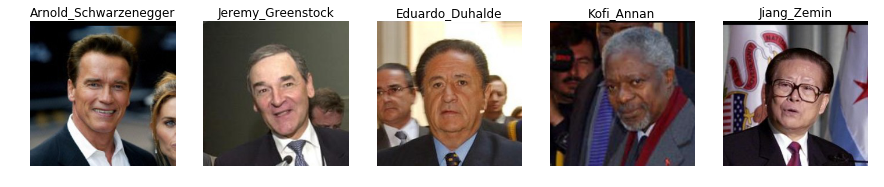

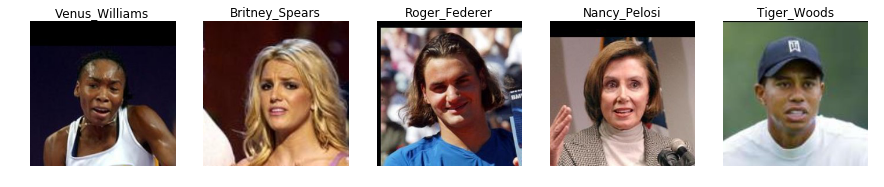

In [8]:
visualize(x_train,y_train)
visualize(x_test,y_test)

You have to implement preprocessing function in the cell below.
Getting an image as an input the this function should detect the face on it, find the facial keypoints and then crop and normalize the image 
according to these keypoints. The output image should contain only the aligned face and should be the tensor of the shape (1, 224, 224, 3).

In [9]:
def preprocess(img):
    """ Your implementation """ 
    pass

#### Visualization of preprocessing

In [ ]:
visualize(x_train,y_train, function = lambda x:preprocess(x)[0])

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [10]:
model = VGG_model('vgg_face_500.h5')

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [11]:
def get_layer_output(images, layer = 'prob'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [12]:
img = cv2.resize(x_train[0], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print out.shape

(1, 500)


You have to implement two functions in the cell below.
The function "classify" should return the name of the most probable person shown on the image, and
"predict_proba" should return the list of probabilities. Now these functions return random result, you should change it.


In [13]:
def classify(img):
    """ Your implementation """ 
    return np.random.choice(classes) #You shoud change this function
    
def predict_proba(img):
    """ Your implementation """ 
    output = np.random.rand(len(classes))
    return output/output.sum() #You shoud change this function

Let us check the accuracy of your classification. Sometimes it is more convenient to classify the block of images simultaneously, so you can change this script if you need. But you have to get the list of the predictions for each of the testing images.

In [14]:
labels = []
for img in x_test:
    label = classify(img)
    labels.append(label)
pickle.dump(labels, open('result_images.pickle', 'wb'))
print 'Classification accuracy:\t%3f' % accuracy_score(labels, y_test)

Classification accuracy:	0.004934


### Visualization of the classification

In [15]:
def top_5_visualization(test_data, test_labels, classes, prediction_function, is_video = False, n_images = 3):
    figure(figsize = (18,10))
    for n,i in enumerate(np.random.randint(len(test_data), size = n_images)):
        plt.subplot(n_images,6,6*n+1)
        plt.axis('off')
        if is_video:
            plt.imshow(test_data[i][0])
        else:
            plt.imshow(test_data[i])
        plt.title('Request')
        preds = prediction_function(test_data[i])
        labels = preds.argsort()[-1:-6:-1]

        for j,l in enumerate(labels):
            plt.subplot(n_images,6, 6*n+j+2)
            plt.axis('off')
            picture = copy(people_faces[classes[l]])
            plt.title('Top-%d'%(j+1))
            if test_labels[i]==classes[l]:
                cv2.rectangle(picture,(0,0),picture.shape[:2], (0,250,0),15)
            plt.imshow(picture)

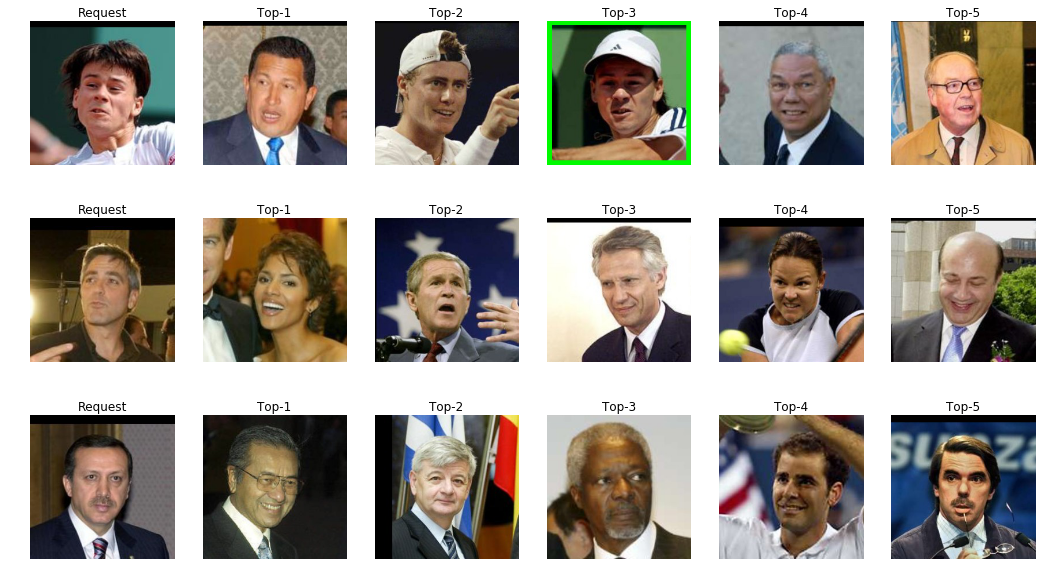

In [16]:
top_5_visualization(x_test, y_test, classes, predict_proba)

## Face recognition in video

Now you have to classify faces in video sequences. Each sequence containes about 125 frames with a face depicted on each frame. You should detect the face, find the keypoints and normalize the images as in the previous task (you can use the same preprocess function). To classify the whole video you can combine the predictions for its frames any way you want (averaging, voting, etc.)

Training data is in the same format as in the first task. There are distinct images with different faces depicted on them. Testing data is the dictionary: the keys are video ids and the values are lists of frames.

In [17]:
video_train, train_labels, video_test, test_labels = load_dataset('video')
video_classes = np.unique(train_labels)
print '%d'%len(video_train), '\ttraining images'
print '%d'%len(video_test), '\ttesting videos'

791 	training images
110 	testing videos


You have to implement two functions in the cell below.
The function "classify" should return the name of the most probable person in video, and
"predict_proba" should return the list of probabilities. Now these functions return random result, you should change it.

Hint: while preprocessing video frames you can use face detector not in all the frames but every few frames and interpolate face detections in other frames. 

In [18]:
def classify_video(video):
    return np.random.choice(video_classes)#You shoud change this function
def predict_proba_video(video):
    output = np.random.rand(len(video_classes))
    return output/output.sum()#You shoud change this function

Let us check the accuracy of your classification. Sometimes it is more convenient to classify the block of images simultaneously, so you can change this script and implement another classification function that takes neural features as the argument if you need. But you have to get the list of the predictions for each of the testing images.

In [19]:
video_labels = []
for video_id in video_test:  
    label = classify_video(video_test[video_id])
    video_labels.append(label)
pickle.dump(video_labels, open('result_video.pickle', 'wb'))

print 'Classification accuracy:\t%3f' % accuracy_score(video_labels, test_labels)

Classification accuracy:	0.000000


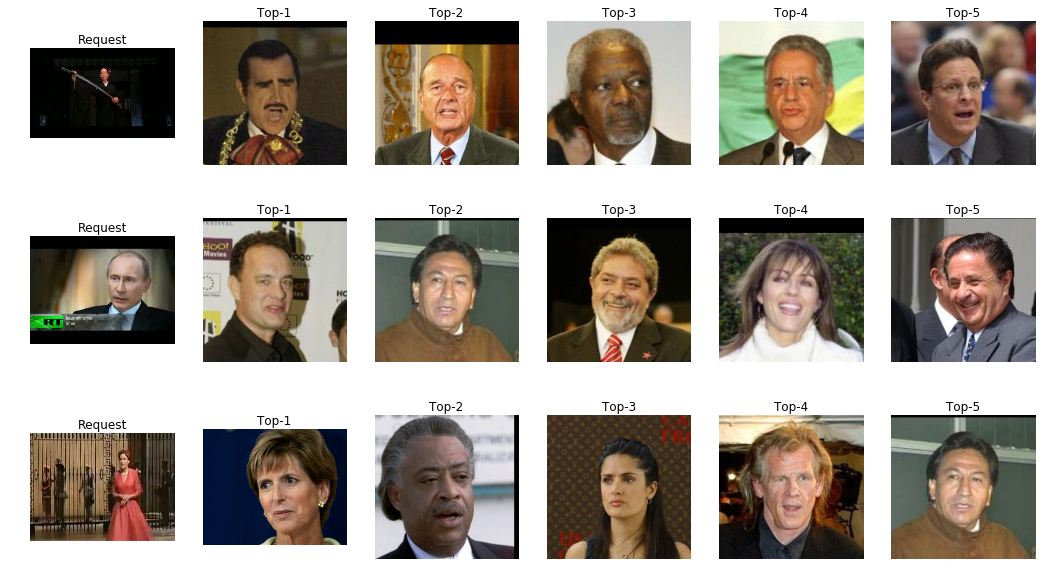

In [20]:
top_5_visualization(video_test, test_labels, video_classes, predict_proba_video, is_video=True)